# 0. Install and Import Dependencies

In [ ]:
! pip install opencv-python matplotlib tensorflow imageio gdown 

In [2]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [5]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  pass

# 1. Data Loading Functions

In [ ]:
import gdown

url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

In [7]:
def load_video(path:str) -> List[float]:
  cap = cv2.VideoCapture(path)
  frames = []
  for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
    ret, frame = cap.read()
    frame = tf.image.rgb_to_grayscale(frame)
    frames.append(frame[190:236,80:220,:])
  cap.release()

  mean = tf.math.reduce_mean(frames)
  std = tf.math.reduce_std(tf.cast(frames, tf.float32))
  return tf.cast((frames - mean), tf.float32) / std

In [8]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!0123456789 "]

In [12]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)

print(f"The vocabulary is {char_to_num.get_vocabulary()}"
      f"(size={char_to_num.vocabulary_size()})")

The vocabulary is ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '](size=41)


In [19]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [14]:
def load_data(path:str):
  path = bytes.decode(path.numpy())
  file_name = path.split('\\')[-1].split('.')[0]
  video_path = os.path.join('data','s1',f'{file_name}.mpg')
  alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
  frames = load_video(video_path)
  alignments = load_alignments(alignment_path)
  return frames, alignments

In [22]:
test_path = '.\\data\\s1\\bbal6n.mpg'

frames, alignments = load_data(tf.convert_to_tensor(test_path))

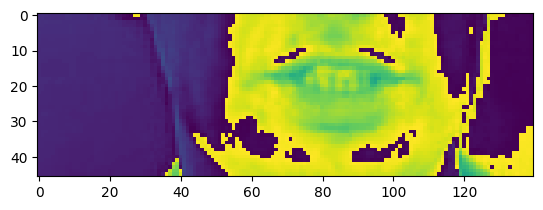

In [34]:
plt.imshow(frames[35])

In [24]:
def mappable_function(path:str) -> List[str]:
  result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
  return result

# 2. Data Pipeline